<a id='home'></a>
### Contents

[Data Loading](#DataLoading)

In [ ]:
%load_ext autoreload
%autoreload 2

In [ ]:
!pip install -q implicit==0.6.1

     |████████████████████████████████| 18.6 MB 370 kB/s 


In [ ]:
import os
import sys
import time
import itertools
from tqdm.notebook import tqdm
import pickle
import json
import joblib
import collections

import numpy as np
import pandas as pd
import matplotlib
from matplotlib_venn import venn2, venn2_circles
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from implicit.nearest_neighbours import (
    BM25Recommender,
    CosineRecommender,
    TFIDFRecommender,
    bm25_weight,
)

In [ ]:
matplotlib.rcParams['figure.figsize'] = (8, 8)
sns.set_style('whitegrid')

In [ ]:
# # Подключение данных гугл диска
# from google.colab import drive
# drive.mount('/content/drive')

In [ ]:
# #!cat /content/drive/MyDrive/spark_colab/spark_colab.sh
# !apt-get install openjdk-8-jdk-headless -qq > /dev/null
# # install spark (change the version number if needed)
# !wget https://archive.apache.org/dist/spark/spark-3.0.0/spark-3.0.0-bin-hadoop3.2.tgz
# # unzip the spark file to the current folder
# !tar xf spark-3.0.0-bin-hadoop3.2.tgz
# !pip install -q findspark
# !pip install -q pyspark

In [ ]:
# # Подключаем спарк
# !bash /content/drive/MyDrive/spark_colab/spark_colab.sh
# os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
# os.environ["SPARK_HOME"] = "/content/spark-3.0.0-bin-hadoop3.2"

# import findspark
# findspark.init()
# from pyspark.sql import SparkSession
# from pyspark.sql import functions as F
# from pyspark.sql.window import Window as W
# spark = SparkSession.builder\
#         .master("local")\
#         .appName("Colab")\
#         .config('spark.ui.port', '4050')\
#         .getOrCreate()
# spark

---

<a id='DataLoading1'></a>
### Data Loading
[contents](#home)

In [ ]:
interactions_df = pd.read_csv('/content/drive/MyDrive/Data/yandex_recsys_2021/reviews.csv')
interactions_df = interactions_df.drop_duplicates(['user_id', 'org_id', 'rating', 'ts']).reset_index(drop=True)
print(f"{interactions_df.shape[0]:,} x {interactions_df.shape[1]:,}")

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:3326: DtypeWarning: Columns (4) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


3,582,797 x 5


In [ ]:
interactions_df.sample(n=5, random_state=42)

,user_id,org_id,rating,ts,aspects
2524386,5739790886870217002,9104453017196776235,5.0,597,NaN
1894739,9460380548980823295,2620271066729040906,5.0,592,NaN
1166835,16140164463624332208,13188723421205067725,5.0,719,NaN
3457148,5640582865203889741,10384826117436540122,5.0,572,NaN
2456924,10381284217585469344,180088829135845110,5.0,684,NaN


In [ ]:
unq_users = set(interactions_df['user_id'])
unq_orgs = set(interactions_df['org_id'])
print(f"#users: {len(unq_users):,}")
print(f"#orgs: {len(unq_orgs):,}")

#users: 1,252,801
#orgs: 66,405


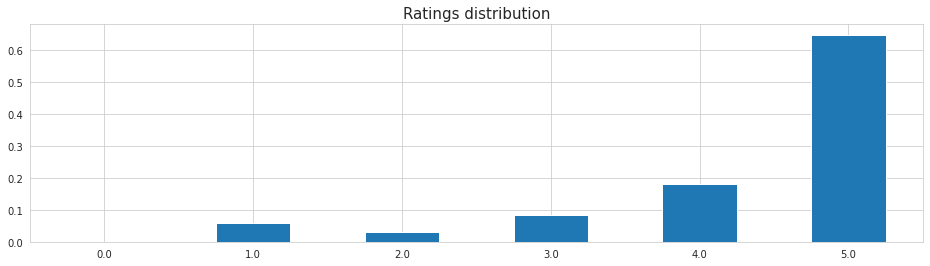

In [ ]:
plt.title(f'Ratings distribution', fontsize=15);
interactions_df.rating.value_counts(1).sort_index().plot(kind='bar', figsize=(16, 4));
plt.tick_params(axis='x', rotation=0);

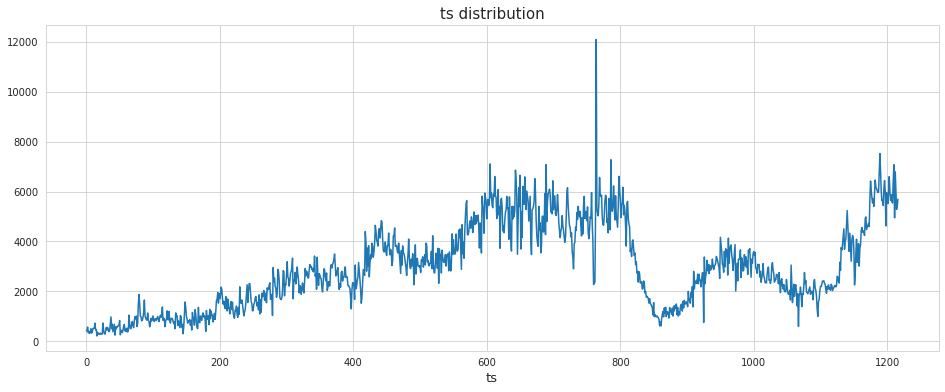

In [ ]:
plt.title(f'ts distribution', fontsize=15);
interactions_df['ts'].value_counts().sort_index().plot(kind='line', figsize=(16, 6));
plt.xlabel('ts', fontsize=13);

In [ ]:
# splitting ts by parts
interactions_df['ts_category'] = pd.qcut(interactions_df['ts'], q=100).apply(lambda x: int(x.right))

In [ ]:
tmp_df = (
    interactions_df
    .groupby(['ts_category'])
    .agg(
        cnt = pd.NamedAgg(column='ts', aggfunc=len),
        n_unq_users = pd.NamedAgg(column='user_id', aggfunc=lambda x: len(set(x))),
        n_unq_orgs = pd.NamedAgg(column='org_id', aggfunc=lambda x: len(set(x))),
    )
    .reset_index()
    .sort_values(by=['ts_category'], ascending=True)
)

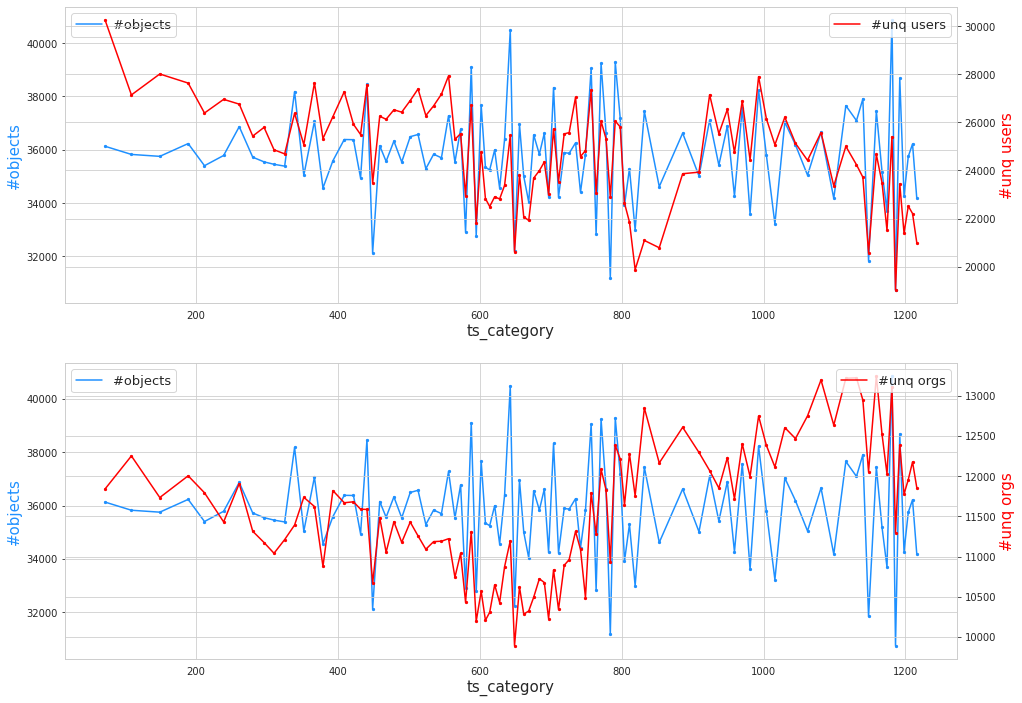

In [ ]:
fig, ax = plt.subplots(nrows=2, figsize=(16, 12))

ax[0].plot(tmp_df['ts_category'], tmp_df['cnt'], color='dodgerblue', label='#objects');
ax[0].scatter(tmp_df['ts_category'], tmp_df['cnt'], color='dodgerblue', s=5);
ax[0].legend(fontsize=13, loc='upper left');
ax[0].set_ylabel('#objects', color='dodgerblue', fontsize=15);
ax[0].set_xlabel('ts_category', fontsize=15);

ax2 = ax[0].twinx()
ax2.plot(tmp_df['ts_category'], tmp_df['n_unq_users'], color='red', label='#unq users');
ax2.scatter(tmp_df['ts_category'], tmp_df['n_unq_users'], color='red', s=5);
ax2.set_ylabel('#unq users', color='red', fontsize=15);
ax2.legend(fontsize=13);

ax[1].plot(tmp_df['ts_category'], tmp_df['cnt'], color='dodgerblue', label='#objects');
ax[1].scatter(tmp_df['ts_category'], tmp_df['cnt'], color='dodgerblue', s=5);
ax[1].legend(fontsize=13, loc='upper left');
ax[1].set_ylabel('#objects', color='dodgerblue', fontsize=15);
ax[1].set_xlabel('ts_category', fontsize=15);


ax2 = ax[1].twinx()
ax2.plot(tmp_df['ts_category'], tmp_df['n_unq_orgs'], color='red', label='#unq orgs');
ax2.scatter(tmp_df['ts_category'], tmp_df['n_unq_orgs'], color='red', s=5);
ax2.set_ylabel('#unq orgs', color='red', fontsize=15);
ax2.legend(fontsize=13, loc='upper right');

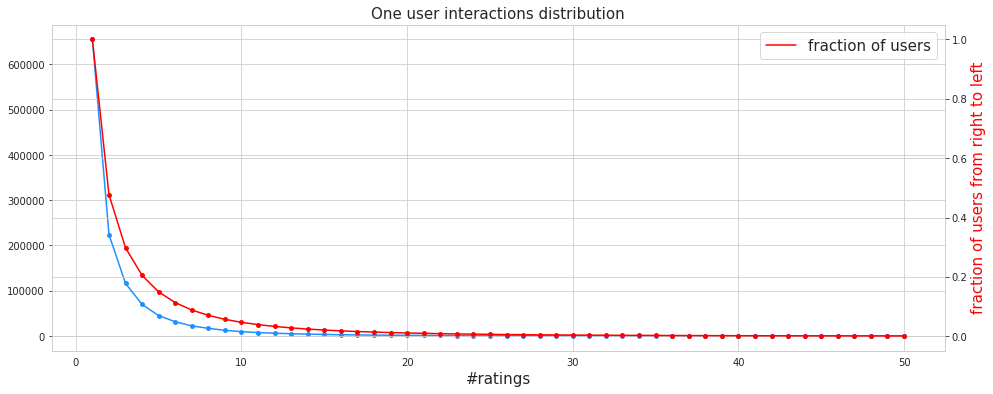

In [ ]:
tmp_df = (
    interactions_df
    .groupby(['user_id'])
    ['org_id']
    .count()
    .reset_index().rename(columns={'org_id': 'cnt'})
    .groupby(['cnt'])
    .count()
    .reset_index().rename(columns={'user_id': 'count'})
    .sort_values(by=['cnt'], ascending=False)
    .assign(count_cumsum_desc = lambda x: x['count'].cumsum())
    .sort_values(by=['cnt'], ascending=True)
)
tmp_df['fraction'] = tmp_df['count_cumsum_desc'] / tmp_df['count'].sum()


N = 50
fig, ax = plt.subplots(figsize=(16, 6))
ax.set_title('One user interactions distribution', fontsize=15)
ax.plot(tmp_df['cnt'].head(N), tmp_df['count'].head(N), color='dodgerblue');
ax.scatter(tmp_df['cnt'].head(N), tmp_df['count'].head(N), color='dodgerblue', s=15);
ax.set_xlabel('#ratings', fontsize=15);

ax2 = ax.twinx()
ax2.plot(tmp_df['cnt'].head(N), tmp_df['fraction'].head(N), color='red', label='fraction of users')
ax2.scatter(tmp_df['cnt'].head(N), tmp_df['fraction'].head(N), color='red', s=15);
ax2.set_ylabel('fraction of users from right to left', fontsize=15, color='red');
ax2.legend(fontsize=15);

In [ ]:
# take only users with 10 and more ratings
user_cnts = (
    interactions_df
    .groupby(['user_id'])
    ['rating']
    .count()
)
needed_users_df = pd.DataFrame(user_cnts[user_cnts >= 10].keys(), columns=['user_id'])

interactions_clear_df = (
    interactions_df
    .merge(
        needed_users_df,
        on=['user_id'],
        how='inner'
    )
)
print(f"{interactions_clear_df.shape[0]:,} x {interactions_clear_df.shape[1]:,}")

1,031,889 x 6


In [ ]:
# Splitting interactions by time
test_ts = interactions_clear_df['ts'].max() - 130

train_interactions = interactions_clear_df.loc[
    (interactions_clear_df['ts'] <= test_ts)
].reset_index(drop=True)

test_interactions = interactions_clear_df.loc[
    (interactions_clear_df['ts'] > test_ts)
].reset_index(drop=True)

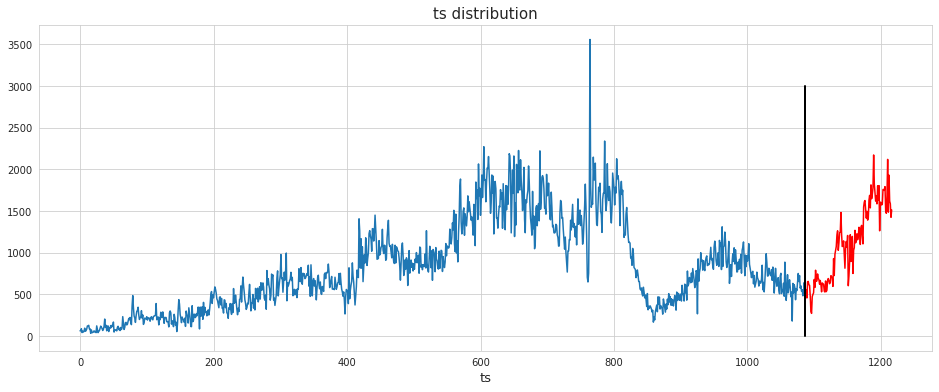

In [ ]:
plt.title(f'ts distribution', fontsize=15);
train_interactions['ts'].value_counts().sort_index().plot(kind='line', figsize=(16, 6));
test_interactions['ts'].value_counts().sort_index().plot(kind='line', figsize=(16, 6), color='red');
plt.plot([test_ts, test_ts], [0, 3000], color='black', lw=2);
plt.xlabel('ts', fontsize=13);

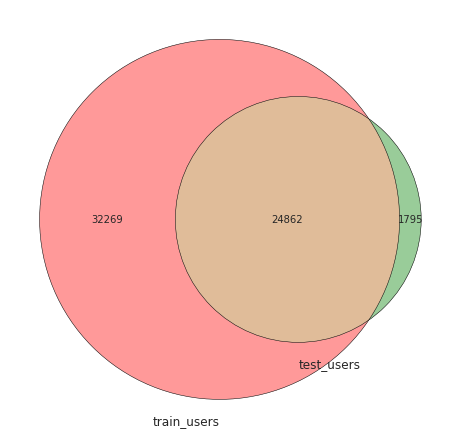

In [ ]:
venn2(
    subsets=[
        set(train_interactions['user_id']),
        set(test_interactions['user_id'])
    ],
    set_labels=['train_users', 'test_users']
);

venn2_circles(
    subsets=[
        set(train_interactions['user_id']),
        set(test_interactions['user_id'])
    ],
    lw=0.5
);

In [ ]:
from implicit.nearest_neighbours import (
    BM25Recommender,
    CosineRecommender,
    TFIDFRecommender,
    bm25_weight,
)

In [ ]:
from scipy.sparse import csr_matrix
from pandas.api.types import CategoricalDtype

def pandas_sparce_pivot(
    df: pd.DataFrame,
    rows_name: str,
    cols_name: str,
    vals_col: str,
    unq_rows_vals: CategoricalDtype=None,
    unq_cols_vals: CategoricalDtype=None
) -> (csr_matrix, CategoricalDtype, CategoricalDtype):

    if unq_rows_vals is None:
        rows_c = CategoricalDtype(sorted(df[rows_name].unique()), ordered=True)
    else:
        rows_c = unq_rows_vals
        
    if unq_cols_vals is None:
        cols_c = CategoricalDtype(sorted(df[cols_name].unique()), ordered=True)
    else:
        cols_c = unq_cols_vals
        
    row = df[rows_name].astype(rows_c).cat.codes
    col = df[cols_name].astype(cols_c).cat.codes
    sparse_matrix = csr_matrix((df[vals_col], (row, col)), \
                               shape=(rows_c.categories.size, cols_c.categories.size))
    return sparse_matrix, rows_c, cols_c
    

In [ ]:
train_user_item_matrix, unq_train_users, unq_train_orgs = pandas_sparce_pivot(
    df=train_interactions,
    rows_name='user_id',
    cols_name='org_id',
    vals_col='rating'
)
print(f"{train_user_item_matrix.shape[0]:,} x {train_user_item_matrix.shape[1]:,}")

test_user_item_matrix, _, _ = pandas_sparce_pivot(
    df=test_interactions,
    rows_name='user_id',
    cols_name='org_id',
    vals_col='rating',
    unq_rows_vals=unq_train_users,
    unq_cols_vals=unq_train_orgs
)
print(f"{test_user_item_matrix.shape[0]:,} x {test_user_item_matrix.shape[1]:,}")

57,131 x 44,652
26,657 x 21,720


In [ ]:
cosine_model = CosineRecommender(K=10)
cosine_model.fit(train_user_item_matrix.T)

/usr/local/lib/python3.7/dist-packages/implicit/utils.py:141: ParameterWarning: Method expects CSR input, and was passed coo_matrix instead. Converting to CSR took 0.01588273048400879 seconds
  ParameterWarning,


  0%|          | 0/57131 [00:00<?, ?it/s]

In [ ]:
itemids, scores = cosine_model.recommend(
    userid=57131, 
    user_items=train_user_item_matrix, 
    N=10, 
    filter_already_liked_items=True, 
    filter_items=None, 
    recalculate_user=False, 
    items=None
)
print(f"itemsids:")
print(itemids)
print(f'scores:')
print(scores)

itemsids:
[ 4103 21438 34657 56672 55847 56565 56172 57090  7666 57055]
scores:
[       nan 0.08043413 0.11242975 0.20496938 0.31580697 0.25
 0.16984156 0.47245559 0.32889676 0.92072174]


---

<a id='DataLoading'></a>
### Problem 14
[contents](#home)

На основе датасета interactions_processed.csv построить рекоменда-
ции фильмов на основе implicit.nearest_neighbours.TFIDFRecommender. На
кросс-валидации подобрать оптимальное число соседей.


In [ ]:
items_df = pd.read_csv('/content/drive/MyDrive/Data/kion_recsys/items.csv')
interactions_df = pd.read_csv('/content/drive/MyDrive/Data/kion_recsys/interactions_processed.csv')
print(f"interactions_df: {interactions_df.shape[0]:,} x {interactions_df.shape[1]:,}")
print(f"items_df: {items_df.shape[0]:,} x {items_df.shape[1]:,}")

In [ ]:
plt.title(f'last_watch_dt distribution', fontsize=15);
interactions_df['last_watch_dt'].value_counts().sort_index().plot(kind='line', figsize=(16, 6));
plt.xlabel('last_watch_dt', fontsize=13);

In [ ]:
id2user_mapping = dict(enumerate(interactions_df['user_id'].unique()))
user2id_mapping = {v: k for k, v in id2user_mapping.items()}

id2item_mapping = dict(enumerate(interactions_df['item_id'].unique()))
item2id_mapping = {v: k for k, v in id2item_mapping.items()}

In [ ]:
last_watch_split_val = str((pd.Timestamp(interactions_df['last_watch_dt'].max()) - pd.DateOffset(days=15)).date())
last_watch_split_val

In [ ]:
train_interactions_df = interactions_df.loc[
    (interactions_df['last_watch_dt'] <= last_watch_split_val)
].reset_index(drop=True)

test_interactions_df = interactions_df.loc[
    (interactions_df['last_watch_dt'] > last_watch_split_val)
].reset_index(drop=True)

unq_train_users = set(train_interactions_df['user_id'])
unq_train_items = set(train_interactions_df['item_id'])
unq_test_users = set(test_interactions_df['user_id'])
unq_test_items = set(test_interactions_df['item_id'])

print(f"train_interactions: {train_interactions_df.shape[0]:,}")
print(f"\tunq_train_users: {len(unq_train_users):,}")
print(f"\tunq_train_items: {len(unq_train_items):,}")
print()
print(f"test_interactions: {test_interactions_df.shape[0]:,}")
print(f"\tunq_test_users: {len(unq_test_users):,}")
print(f"\tunq_test_items: {len(unq_test_items):,}")

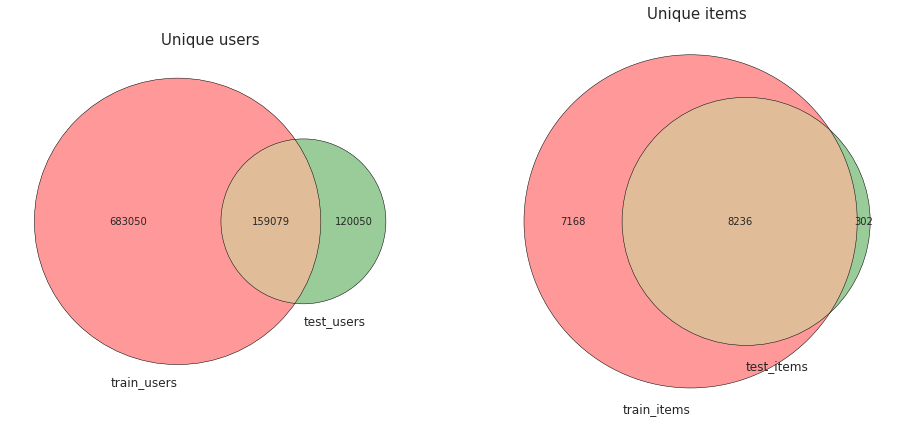

In [ ]:
fig, ax = plt.subplots(ncols=2, figsize=(16, 8))

ax[0].set_title(f'Unique users', fontsize=15);
venn2(
    subsets=[
        set(train_interactions_df['user_id']),
        set(test_interactions_df['user_id'])
    ],
    set_labels=['train_users', 'test_users'],
    ax=ax[0]
);

venn2_circles(
    subsets=[
        set(train_interactions_df['user_id']),
        set(test_interactions_df['user_id'])
    ],
    lw=0.5,
    ax=ax[0]
);

ax[1].set_title(f'Unique items', fontsize=15);
venn2(
    subsets=[
        set(train_interactions_df['item_id']),
        set(test_interactions_df['item_id'])
    ],
    set_labels=['train_items', 'test_items'],
    ax=ax[1]
);

venn2_circles(
    subsets=[
        set(train_interactions_df['item_id']),
        set(test_interactions_df['item_id'])
    ],
    lw=0.5,
    ax=ax[1]
);

In [ ]:
from scipy import sparse as sp

def get_coo_matrix(df, 
                   user_col='user_id', 
                   item_col='item_id', 
                   weight_col=None, 
                   users_mapping={}, 
                   items_mapping={}):
    
    if weight_col is None:
        weights = np.ones(len(df), dtype=np.float32)
    else:
        weights = df[weight_col].astype(np.float32)

    interaction_matrix = sp.coo_matrix((
        weights, 
        (
            df[user_col].map(users_mapping.get), 
            df[item_col].map(items_mapping.get)
        )
    ))
    return interaction_matrix

In [ ]:
train_user_item_matrix = get_coo_matrix(
    df=train_interactions_df, 
    user_col='user_id', 
    item_col='item_id', 
    users_mapping=user2id_mapping, 
    items_mapping=item2id_mapping,
).tocsr()

test_user_item_matrix = get_coo_matrix(
    df=test_interactions_df, 
    user_col='user_id', 
    item_col='item_id', 
    users_mapping=user2id_mapping, 
    items_mapping=item2id_mapping,
).tocsr()

print(f"train_user_item_matrix: {train_user_item_matrix.shape[0]:,} x {train_user_item_matrix.shape[1]:,}")
print(f"test_user_item_matrix: {test_user_item_matrix.shape[0]:,} x {test_user_item_matrix.shape[1]:,}")

In [ ]:
model = TFIDFRecommender(K=10)
model.fit(train_user_item_matrix.T, show_progress=True)

In [ ]:
# pickle.dump(model, open('/content/drive/MyDrive/tmp/tfidf_recommender_kion_recsys.pkl', mode='wb'))
# model_new = pickle.load(open('/content/drive/MyDrive/tmp/tfidf_recommender_kion_recsys.pkl', mode='rb'))

In [ ]:
itemid2title_dict = dict(zip(items_df['item_id'], items_df['title']))

user2items_history_dict = (
    train_interactions_df
    .groupby(['user_id'])
    ['item_id']
    .apply(lambda x: [itemid2title_dict[item] for item in x])
    .to_dict()
)

In [ ]:
np.random.seed(8) #2, 4, 5, 8
current_user = np.random.choice(list(unq_train_users))
print("current_user:", current_user)
print(user2items_history_dict[current_user])
print('\n' + '='*100 + '\n')

similar_users, scores = model.similar_items(itemid=user2id_mapping[current_user])

for i, neigh_user in enumerate(similar_users, start=1):
    print(f'similar_user{i}:', neigh_user)
    print(user2items_history_dict[id2user_mapping[neigh_user]])
    print()


current_user: 774680
['Гнев человеческий', 'Дьявол носит Prada', 'Стражи Галактики', 'Ford против Ferrari', 'Зверополис', 'Стражи Галактики. Часть 2', 'Анатомия страсти', 'Мстители: Война бесконечности', 'Звезда родилась', 'Мстители: Финал']


similar_user1: 290291
['Гнев человеческий', 'Дьявол носит Prada', 'Стражи Галактики', 'Ford против Ferrari', 'Зверополис', 'Стражи Галактики. Часть 2', 'Анатомия страсти', 'Мстители: Война бесконечности', 'Звезда родилась', 'Мстители: Финал']

similar_user2: 429086
['Звезда родилась', 'Клиника счастья', 'Хрустальный', 'Дуров']

similar_user3: 576527
['Стражи Галактики. Часть 2', 'Мстители: Финал', 'Стражи Галактики', 'Мстители: Война бесконечности']

similar_user4: 122575
['Мстители: Финал', 'Зверополис', 'Стражи Галактики', 'Стражи Галактики. Часть 2', 'Мстители: Война бесконечности', 'Холодное сердце II']

similar_user5: 256316
['Стражи Галактики. Часть 2', 'Клиника счастья', 'Стражи Галактики', 'Мстители: Финал', 'Мстители: Война бесконечности

### Problem 10
Сделайте Tf-idf преобразование текстов и примените метод K-NN (с
косинусной метрикой) для классификации текстов. При каком количестве
соседей достигается наибольшее качество на валидации? Как ещё можно
улучшить качество классификации?

In [ ]:
from pprint import pprint

In [ ]:
from sklearn.datasets import fetch_20newsgroups
data = fetch_20newsgroups(subset='all', remove=('headers', 'footers', 'quotes'))

In [ ]:
target2name_mapping = dict(enumerate(data.target_names))
targets = data.target
texts_list = data.data
print(f"#texts: {len(data.data):,}")
pprint(target2name_mapping)

#texts: 18,846
{0: 'alt.atheism',
 1: 'comp.graphics',
 2: 'comp.os.ms-windows.misc',
 3: 'comp.sys.ibm.pc.hardware',
 4: 'comp.sys.mac.hardware',
 5: 'comp.windows.x',
 6: 'misc.forsale',
 7: 'rec.autos',
 8: 'rec.motorcycles',
 9: 'rec.sport.baseball',
 10: 'rec.sport.hockey',
 11: 'sci.crypt',
 12: 'sci.electronics',
 13: 'sci.med',
 14: 'sci.space',
 15: 'soc.religion.christian',
 16: 'talk.politics.guns',
 17: 'talk.politics.mideast',
 18: 'talk.politics.misc',
 19: 'talk.religion.misc'}


In [ ]:
# example of texts and targets
np.random.seed(3)
random_id = np.random.randint(len(texts_list))
print(f"random_id: {random_id}")
print("text:")
print(texts_list[random_id])
print('\n' + '='*100 + '\n')
print("target:")
print(target2name_mapping[targets[random_id]])

random_id: 5994
text:

[ a lot of religious opinions and quotations from the Bible and from 
many Catholic theologians and Papal Bulls ]

[ which, although introduced with a smiley, was not as funny as it
might have been (notable exception: subject headers such as "ONE'S 
DICK IS ONE'S INSTRUMENT OF REDEMPTION." ]

[ and indeed, the posting seemed to be more a vehicle for the
religious text than for any "literary/moral analysis" ]

I am surprised and saddened. I would expect this kind of behavior
from the Evangelical Born-Again Gospel-Thumping In-Your-Face We're-
The-Only-True-Christian Protestants, but I have always thought 
that Catholics behaved better than this.

Friend Dennis, I urge you to follow the example of your fellow
Catholics, of who I count many dozens as my friends, and practice
your faith through good example and decent living and respect
for the common humanity of others. Please do not stoop to the
level of the E B-A G-T I-Y-F W-T-O-T-C Protestants, who think
that the 

In [ ]:
import spacy
#loading the english language small model of spacy
nlp = spacy.load('en_core_web_sm')
stopwords = nlp.Defaults.stop_words
print(len(stopwords))
print(stopwords)

326
{'itself', 'thus', '‘ll', 'various', 'would', 'thru', 'hers', 'whole', 'amongst', 'besides', 'least', '‘d', 'whatever', 'mine', 'about', 'how', 'within', 'afterwards', 'even', 'why', 'name', 'using', "'re", 'towards', 'give', '’re', 'to', 'throughout', 'alone', 'yours', 'except', 'hundred', 'eight', 'just', 'two', '’m', 'are', 'our', 'become', 'others', 'themselves', 'both', 're', 'whoever', 'much', 'nobody', 'but', 'everyone', '’s', 'us', 'until', 'yourself', 'since', 'anyway', 'whether', 'many', 'before', 'for', 'top', 'each', 'became', 'ten', 'during', 'of', 'once', 'now', 'something', 'on', 'seems', '’ll', 'hereafter', 'front', 'ca', 'more', 'with', 'him', 'again', 'every', 'unless', 'she', 'which', 'another', 'in', "'d", "'m", 'whom', 'several', 'is', 'already', "n't", 'formerly', 'call', 'will', 'was', 'whereby', 'perhaps', 'ever', 'nothing', 'between', 'were', 'moreover', 'make', 'latter', 'whereas', 'all', 'regarding', "'ll", 'thereby', 'yourselves', 'meanwhile', 'my', 'not

In [ ]:
%%time
processed_texts_list = []
for text in tqdm(texts_list):
    processed_text = [
        str(token.lemma_).lower() for token in nlp(text) 
        if not token.is_stop 
        and str(token).strip() != ''
    ]
    processed_texts_list.append(processed_text)

  0%|          | 0/18846 [00:00<?, ?it/s]

CPU times: user 10min 59s, sys: 11.8 s, total: 11min 10s
Wall time: 11min 10s


In [ ]:
??np.array_split

In [ ]:
# splitting texts into train and test parts
np.random.seed(42)
tr_idxs, te_idxs = np.array_split(
    np.random.permutation(np.arange(len(processed_texts_list))),
    indices_or_sections=[int(len(processed_texts_list)*0.65)]
)
print(f"tr_idxs: {len(tr_idxs):,}")
print(f"te_idxs: {len(te_idxs):,}")

tr_targets = targets[tr_idxs]
te_targets = targets[te_idxs]

tr_idxs: 12,249
te_idxs: 6,597


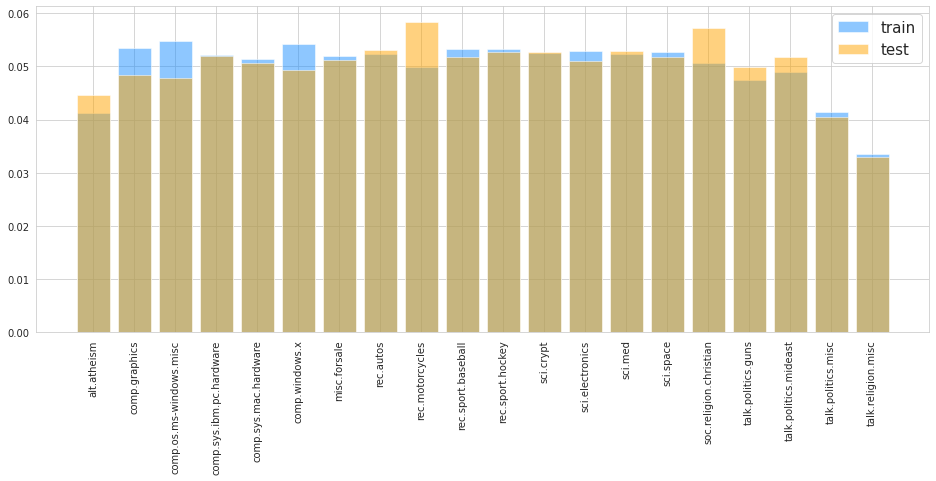

In [ ]:
# target distributions viz
tmp_df1 = pd.DataFrame(np.unique(tr_targets, return_counts=True)).T
tmp_df1.columns = ['classes', 'counts_tr']
tmp_df2 = pd.DataFrame(np.unique(te_targets, return_counts=True)).T
tmp_df2.columns = ['classes', 'counts_te']
tmp_df = (
    tmp_df1
    .merge(
        tmp_df2,
        on=['classes'],
        how='outer'
    )
    .fillna(0)
)

plt.figure(figsize=(16, 6))
plt.bar(
    [target2name_mapping[class_] for class_ in tmp_df['classes']], 
    tmp_df['counts_tr']/tmp_df['counts_tr'].sum(), color='dodgerblue', label='train', 
    alpha=0.5,
);
plt.bar(
    [target2name_mapping[class_] for class_ in tmp_df['classes']], 
    tmp_df['counts_te']/tmp_df['counts_te'].sum(), color='orange', label='test',
    alpha=0.5,
);
plt.xticks(tr_classes)
plt.tick_params(axis='x', rotation=90);
plt.legend(fontsize=15);

In [ ]:
# json.dump(
#     processed_texts_list,
#     open('/content/drive/MyDrive/tmp/processed_texts_list.json', mode='w', encoding='utf-8'),
#     ensure_ascii=False,
#     indent=2
# )
# processed_texts_list = json.load(
#     open('/content/drive/MyDrive/tmp/processed_texts_list.json', mode='r', encoding='utf-8')
# )
# print(len(processed_texts_list))

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.neighbors import KNeighborsClassifier

In [ ]:
%%time
tf_idf = TfidfVectorizer(
    analyzer='word',
    ngram_range=(1, 3),
    max_df=0.98,
    min_df=4,
    max_features=20_000
)
tf_idf.fit([' '.join(text) for text in np.array(processed_texts_list)[tr_idxs]])
X_tr = tf_idf.transform([' '.join(text) for text in np.array(processed_texts_list)[tr_idxs]])
X_te = tf_idf.transform([' '.join(text) for text in np.array(processed_texts_list)[te_idxs]])
print(f"X_tr: {X_tr.shape[0]:,} x {X_tr.shape[1]:,}")
print(f"X_te: {X_te.shape[0]:,} x {X_te.shape[1]:,}")

X_tr: 12,249 x 20,000
X_te: 6,597 x 20,000


In [ ]:
%%time
model = KNeighborsClassifier(n_neighbors=1)
model.fit(X_tr, tr_targets)

CPU times: user 3.42 ms, sys: 1.99 ms, total: 5.41 ms
Wall time: 5.42 ms


KNeighborsClassifier(n_neighbors=1)

In [ ]:
from sklearn.metrics import accuracy_score

In [ ]:
train_accuracy = accuracy_score(
    y_true=tr_targets,
    y_pred=model.predict(X_tr)
)
test_accuracy = accuracy_score(
    y_true=te_targets,
    y_pred=model.predict(X_te)
)
print(f"train_accuracy: {round(train_accuracy, 4)}")
print(f"test_accuracy: {round(test_accuracy, 4)}")

train_accuracy: 0.9704
test_accuracy: 0.1951


In [ ]:
from sklearn.model_selection import cross_val_score, KFold

In [ ]:
param_name = 'n_neighbors'
param_vals = [1, 3, 5, 7, 9, 10, 11, 12, 15, 20, 21, 30, 50, 100]
metric_vals = []
for param in tqdm(param_vals):
    curr_model = KNeighborsClassifier(**{param_name: param})
    folds_scores = cross_val_score(
        estimator=curr_model,
        X=X_tr,
        y=tr_targets,
        groups=None,
        scoring='accuracy',
        cv=KFold(n_splits=5),
        n_jobs=-1,
        verbose=0
    )
    metric_vals.append(folds_scores)
    print(f'param: {param}\tmean accuracy: {round(np.mean(folds_scores), 4)}')

  0%|          | 0/14 [00:00<?, ?it/s]

param: 1	mean accuracy: 0.1733
param: 3	mean accuracy: 0.1478
param: 5	mean accuracy: 0.1106
param: 7	mean accuracy: 0.1014
param: 9	mean accuracy: 0.0974
param: 10	mean accuracy: 0.0947
param: 11	mean accuracy: 0.0959
param: 12	mean accuracy: 0.0939
param: 15	mean accuracy: 0.0891
param: 20	mean accuracy: 0.0817
param: 21	mean accuracy: 0.0827
param: 30	mean accuracy: 0.0793
param: 50	mean accuracy: 0.0707
param: 100	mean accuracy: 0.065


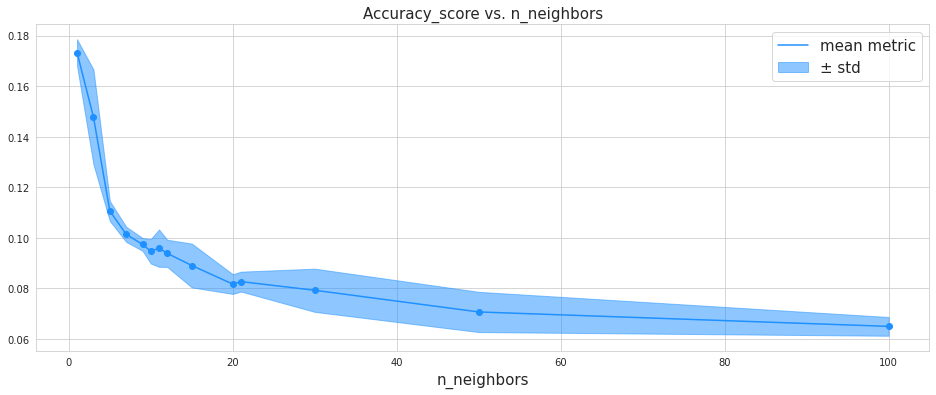

In [ ]:
mean_metric = np.array([np.mean(fold_vals) for fold_vals in metric_vals])
std_metric = np.array([np.std(fold_vals) for fold_vals in metric_vals])


plt.figure(figsize=(16, 6))
plt.title(f'Accuracy_score vs. {param_name}', fontsize=15);
plt.plot(param_vals, mean_metric, color='dodgerblue', label='mean metric');
plt.scatter(param_vals, mean_metric, color='dodgerblue');
plt.fill_between(param_vals, mean_metric - std_metric, mean_metric + std_metric, color='dodgerblue', alpha=0.5, 
                 label='± std');
plt.xlabel(param_name, fontsize=15);
plt.legend(fontsize=15);

In [ ]:
%%time
# searching neighbors 'by hands'
from scipy.spatial.distance import cdist
eucl_dist_matr = cdist(XA=X_tr.toarray(), XB=X_te.toarray(), metric='euclidean')
cosine_dist_matr = cdist(XA=X_tr.toarray(), XB=X_te.toarray(), metric='cosine')

# eucl_argdist = eucl_dist_matr.argsort(axis=1)
# cosine_argdist = cosine_dist_matr.argsort(axis=1)

In [ ]:
from sklearn.metrics.pairwise import pairwise_distances

In [ ]:
%%time
sparce_eucl_dist = pairwise_distances(X=X_tr, Y=X_te, metric='euclidean')